# Effect of AI on Customer Churn


## Load the required libraries

In [13]:
install.packages("tidymodels")
install.packages("aod")
install.packages("glmnet")
install.packages("ggcorrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in install.packages("glmnet"):
“installation of package ‘glmnet’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [14]:
# Installing libraries
library(tidymodels)
library(tidyverse)
library(ggcorrplot)
library(readr)
library(aod)
library(glmnet)
library(caret)
require(gridExtra)

# Setting a seed so our analysis is random but reproducible
set.seed(2005)

Loading required package: lattice


Attaching package: ‘caret’


The following objects are masked from ‘package:yardstick’:

    precision, recall, sensitivity, specificity


The following object is masked from ‘package:purrr’:

    lift


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Read the data 

In [31]:
#read data
training_data <- read.csv("train.csv")
testing_data <- read.csv("test.csv")

#convert Churn from interger to factor from training_data
training_data$Customer_Churn <- as.factor(training_data$Customer_Churn)


#convert Churn from interger to factor from testing_data
testing_data$Customer_Churn <- as.factor(testing_data$Customer_Churn)

#preview the dataset
glimpse(training_data)


Rows: 5,000
Columns: 10
$ ID                               <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…
$ Age                              <int> 59, 49, 35, 63, 28, 41, 59, 39, 43, 3…
$ AI_Interaction_Level             <int> 2, 2, 2, 2, 4, 3, 2, 3, 3, 4, 4, 2, 2…
$ Satisfaction_with_AI_Services    <int> 7, 6, 3, 3, 6, 1, 8, 8, 8, 6, 5, 10, …
$ AI_Personalization_Effectiveness <int> 7, 5, 3, 3, 6, 1, 9, 8, 9, 6, 6, 10, …
$ AI_Response_Time                 <int> 2, 1, 3, 2, 1, 3, 1, 2, 2, 1, 2, 2, 1…
$ Overall_Usage_Frequency          <int> 18, 3, 8, 6, 11, 28, 10, 12, 13, 26, …
$ Customer_Service_Interactions    <int> 5, 2, 2, 6, 3, 2, 1, 10, 8, 3, 0, 1, …
$ Change_in_Usage_Patterns         <int> 2, 0, 1, 2, -1, -1, -2, -2, -1, -1, 0…
$ Customer_Churn                   <fct> 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0…


## Data summary


In [32]:
# Display the observations of customer churn

total_observation_count <- nrow(training_data)

observation_count_summary <- training_data |>
    group_by(Customer_Churn) |>
    summarize(number_of_observations = n(),
              percentage = (n() / total_observation_count) * 100)

observation_count_summary

Customer_Churn,number_of_observations,percentage
<fct>,<int>,<dbl>
0,2909,58.18
1,2091,41.82


In [33]:
# Display the average value of all predictor variables

average_value_summary <- training_data |>
    group_by(Customer_Churn) |>
 rename_with(~ paste(.x, "average", sep = "_"), -Customer_Churn) |>
    summarize(across(everything(), ~ mean(.x, na.rm = TRUE)))

average_value_summary

Customer_Churn,ID_average,Age_average,AI_Interaction_Level_average,Satisfaction_with_AI_Services_average,AI_Personalization_Effectiveness_average,AI_Response_Time_average,Overall_Usage_Frequency_average,Customer_Service_Interactions_average,Change_in_Usage_Patterns_average
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2524.688,41.40976,2.591612,5.761430,5.765555,1.993125,15.66140,5.056377,-0.03850120
1,2466.849,44.19608,2.297944,5.161645,5.192253,1.965567,15.31133,5.079866,0.04160689


## Visualization of training data

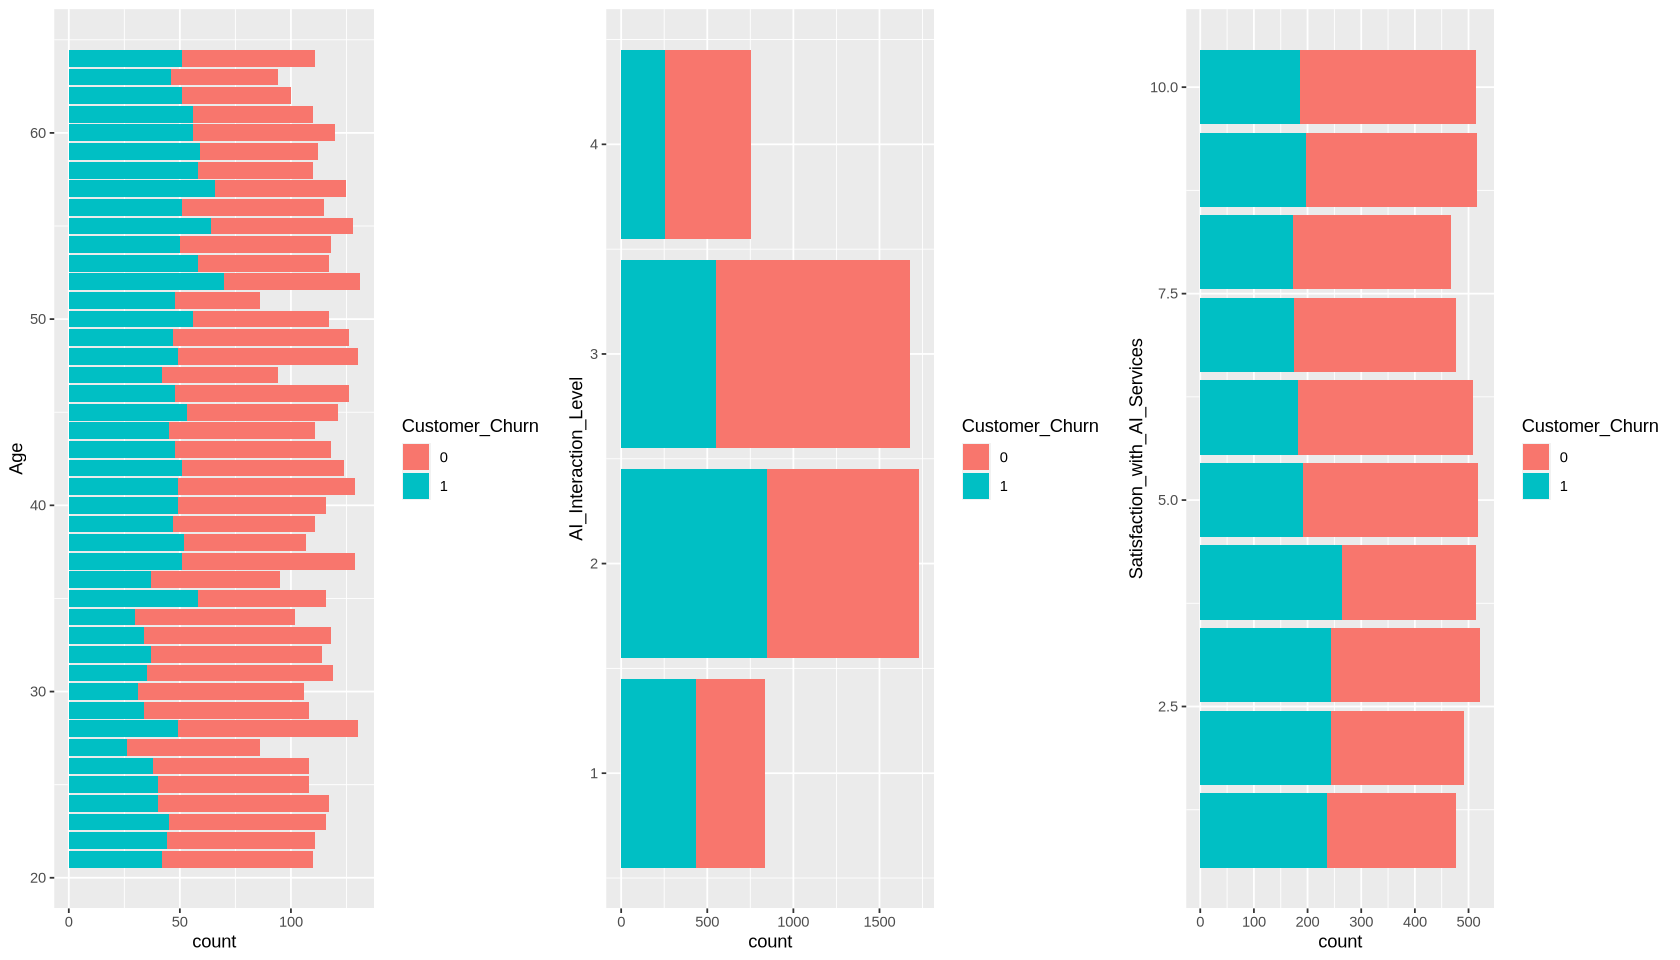

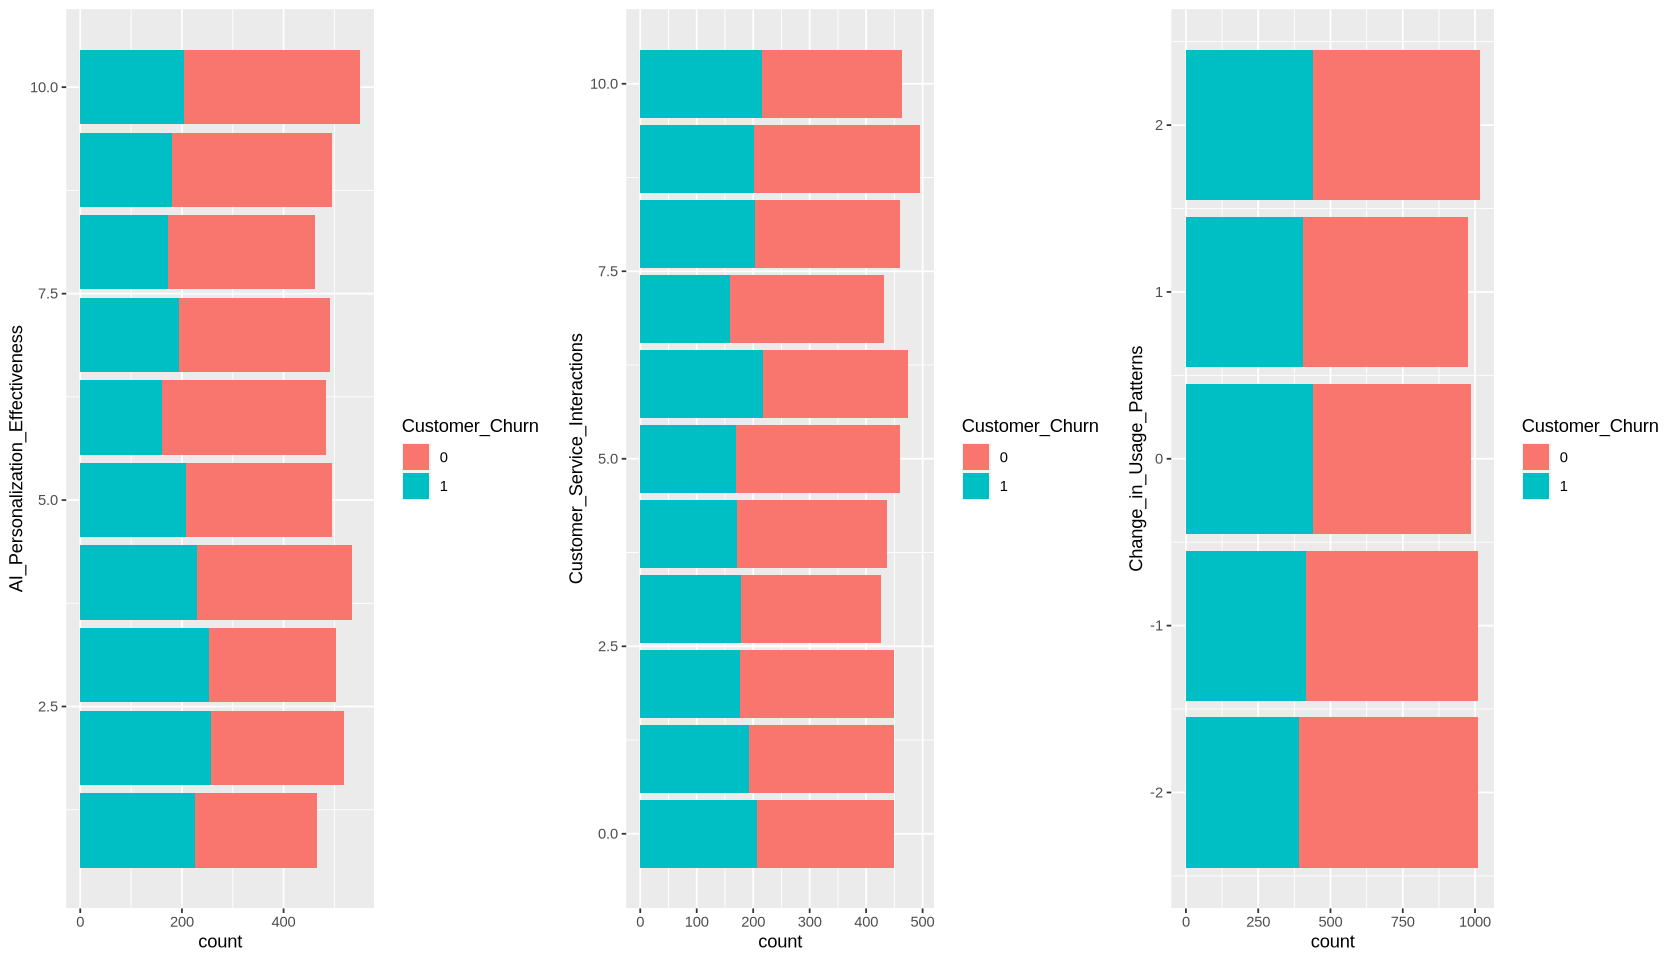

In [34]:
# Visualize the distribution of our relevant feature variables
options(repr.plot.width = 14, repr.plot.height = 8)

age_plot <- ggplot(training_data, aes(Age, fill = Customer_Churn)) +
    geom_bar() +
    coord_flip()

ai_interaction_plot <- ggplot(training_data, aes(AI_Interaction_Level, fill = Customer_Churn)) +
    geom_bar() +
    coord_flip()

satisfaction_plot <- ggplot(training_data, aes(Satisfaction_with_AI_Services, fill = Customer_Churn)) +
    geom_bar() +
    coord_flip()

persionalization_plot <- ggplot(training_data, aes(AI_Personalization_Effectiveness, fill = Customer_Churn)) +
    geom_bar() +
    coord_flip()

response_time_plot <- ggplot(training_data, aes(AI_Response_Time, fill = Customer_Churn)) +
    geom_bar() +
    coord_flip()

usage_frequency_plot <- ggplot(training_data, aes(Overall_Usage_Frequency, fill = Customer_Churn)) +
    geom_bar() +
    coord_flip()

customer_service_int_plot <- ggplot(training_data, aes(Customer_Service_Interactions, fill = Customer_Churn)) +
    geom_bar() +
    coord_flip()

usage_patterns_plot <- ggplot(training_data, aes(Change_in_Usage_Patterns, fill = Customer_Churn)) +
    geom_bar() +
    coord_flip()

grid.arrange(age_plot, ai_interaction_plot, satisfaction_plot, ncol=3)
grid.arrange(persionalization_plot, customer_service_int_plot,usage_patterns_plot, ncol=3)

## Correlation between variables 

ERROR: Error in train$Customer_Churn: object of type 'closure' is not subsettable


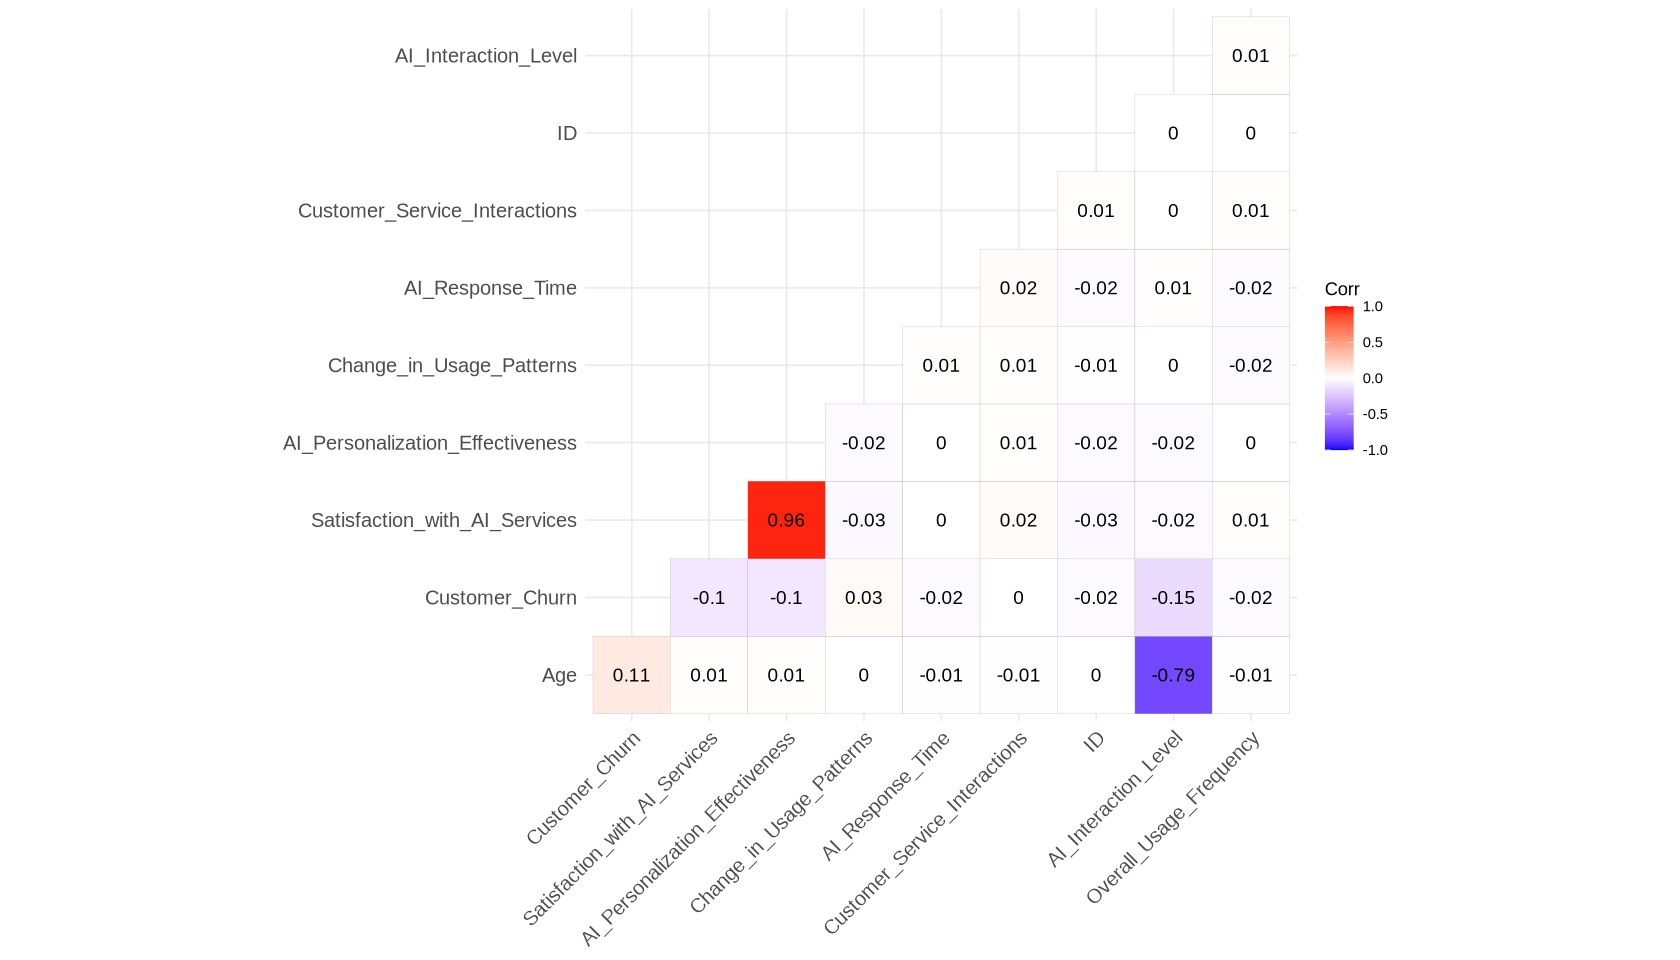

In [35]:
train_non_factor <- training_data
train_non_factor$Customer_Churn <- as.numeric(training_data$Customer_Churn)

# Correlation for different combinations of variables
correlation<- train_non_factor |> cor(use="complete.obs") # find the correlation
ggcorrplot(correlation, 
          hc.order = TRUE, 
          lab = TRUE, 
          type = "lower");

# Comparing the Variables
compare_customers <- function(){
    ggplot(churn, aes(x = Customer_Churn, color = as.factor(AI_Interaction_Level))) +
    geom_histogram(fill = "white", bins = 10)
}

table(train$Customer_Churn)

## Making predictions based on the testing data

In [36]:
# Train a logistic regression model
model <- logistic_reg(mixture = double(1), penalty = double(1)) %>%
  set_engine("glmnet") %>%
  set_mode("classification") %>%
  fit(Customer_Churn ~ ., data = training_data)

# Model summary
tidy(model)

# Class Predictions
pred_class <- predict(model,
                      new_data = testing_data,
                      type = "class")

# Class Probabilities
pred_proba <- predict(model,
                      new_data = testing_data,
                      type = "prob")

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),1.371025e+00,0
ID,-3.188019e-05,0
Age,-3.887422e-03,0
AI_Interaction_Level,-3.744968e-01,0
Satisfaction_with_AI_Services,-6.354216e-02,0
AI_Personalization_Effectiveness,-1.197559e-02,0
AI_Response_Time,-3.967182e-02,0
Overall_Usage_Frequency,-4.303996e-03,0
Customer_Service_Interactions,3.641815e-03,0


## Performing logistic regression - Hyperparameter Tuning

In [37]:
# Define the logistic regression model with penalty and mixture hyperparameters
log_reg <- logistic_reg(mixture = tune(), penalty = tune(), engine = "glmnet")

# Define the grid search for the hyperparameters
grid <- grid_regular(mixture(), penalty(), levels = c(mixture = 4, penalty = 3))

# Define the workflow for the model
log_reg_wf <- workflow() %>%
  add_model(log_reg) %>%
  add_formula(Customer_Churn ~ .)

# Define the resampling method for the grid search
folds <- vfold_cv(training_data, v = 5)

# Tune the hyperparameters using the grid search
log_reg_tuned <- tune_grid(
  log_reg_wf,
  resamples = folds,
  grid = grid,
  control = control_grid(save_pred = TRUE))

select_best(log_reg_tuned, metric = "roc_auc")

penalty,mixture,.config
<dbl>,<dbl>,<chr>
1e-10,0,Preprocessor1_Model01


We can see that Model 7 would work best with penalty from 1e-10

## Performing logistic regression - Applying model

In [44]:
log_reg_final <- logistic_reg(penalty = 1e-10 , mixture = 0) %>%
                 set_engine("glmnet") %>%
                 set_mode("classification") %>%
                 fit(Customer_Churn~., data = training_data)

# Evaluate the model performance on the testing set
pred_class <- predict(log_reg_final,
                      new_data = testing_data,
                      type = "class")
results <- testing_data %>%
  select(Customer_Churn) %>%
  bind_cols(pred_class, pred_proba)

# Create confusion matrix
conf_mat(results, truth = Customer_Churn,
         estimate = .pred_class)

accuracy(results, truth = Customer_Churn, estimate = .pred_class)

          Truth
Prediction   0   1
         0 569 377
         1 145 159

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5824


## Conclusion 

In [43]:
# Downloading Prediction to further conclusion
write.csv(results, "prediction.csv", row.names = FALSE, sep = ",")

Warning message in write.csv(results, "prediction.csv", row.names = FALSE, sep = ","):
“attempt to set 'sep' ignored”
